## Data Preprocessing

In [2]:
# Import essential libraries and modules
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset directory
train_data_dir = "../input/labeled-chest-xray-images/chest_xray/train"
test_data_dir = "../input/labeled-chest-xray-images/chest_xray/test"

# Set the hyperparameters
img_width = 224
img_height = 224
batch_size = 16
seed = 123

# Define the data generators with preprocessing steps
train_data_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)
test_data_generator = ImageDataGenerator(rescale = 1./255)

# Load the training and validation datasets using the data generator
train_generator = train_data_generator.flow_from_directory(
                  train_data_dir,
                  target_size = (img_width, img_height),
                  batch_size = batch_size,
                  shuffle = True,
                  seed = seed,
                  color_mode = 'rgb',
                  class_mode = 'binary',
                  subset = 'training')
    
validation_generator = train_data_generator.flow_from_directory(
                       train_data_dir,
                       target_size = (img_width, img_height),
                       batch_size = batch_size,
                       shuffle = True,
                       seed = seed,
                       color_mode = 'rgb',
                       class_mode = 'binary',
                       subset ='validation')

# Load the test dataset using the data generator
test_generator = test_data_generator.flow_from_directory(
                 test_data_dir,
                 target_size = (img_width, img_height),
                 batch_size = batch_size,
                 shuffle = False,
                 color_mode = 'rgb',
                 class_mode = 'binary')

Found 4448 images belonging to 2 classes.
Found 784 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## The sample images for the 'Pneumonia' and 'Normal' patients

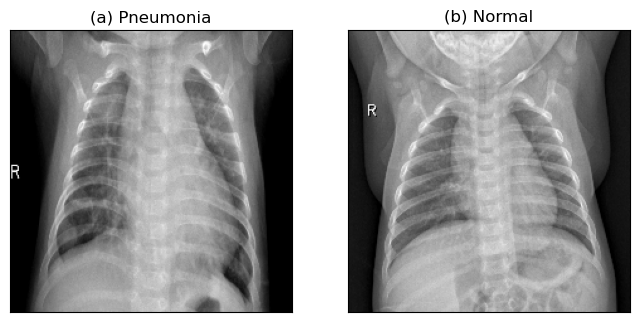

In [3]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# Set the path to the train dataset for pneumonia and normal patients
train_path_pneumonia = "../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA"
train_path_normal = "../input/labeled-chest-xray-images/chest_xray/train/NORMAL"

# Get a list of all the image filenames in the train dataset directory
image_filenames_pneumonia = os.listdir(train_path_pneumonia)
image_filenames_normal = os.listdir(train_path_normal)

# Load the two selected images from pneumania and normal images, respectively
img1 = cv2.imread(os.path.join(train_path_pneumonia, image_filenames_pneumonia[1]), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join(train_path_normal, image_filenames_normal[1]), cv2.IMREAD_GRAYSCALE)

# Convert the image to RGB
rgb_img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

# Resize the images to the same size
rgb_img1 = cv2.resize(rgb_img1, (224, 224))
rgb_img2 = cv2.resize(rgb_img2, (224, 224))

# Create a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Display the first image on the first subplot
ax[0].imshow(rgb_img1)
ax[0].set_title("(a) Pneumonia")
ax[0].set_xticks([])
ax[0].set_yticks([])

# Display the second image on the second subplot
ax[1].imshow(rgb_img2)
ax[1].set_title("(b) Normal")
ax[1].set_xticks([])
ax[1].set_yticks([])

# Show the figure
plt.show()

## Transfer Learning: Pre-trained ResNet50 model on ImageNet dataset

In [4]:
#import essential libraries and modules
from keras.applications.resnet import ResNet50
from keras.layers import Input, Dense, Flatten
from keras.models import Model


#Pretrained ResNet50 model on the ImageNet database
base_model = ResNet50(weights = 'imagenet',
                      input_shape = (img_width, img_height, 3),
                      include_top = False)

#Freeze the layers of ResNet50 model
for layer in base_model.layers:
    layer.trainable = False

def resnet_50_imagenet():
    x = base_model.output
    x = Flatten()(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs = base_model.input, outputs = outputs)
    return model

94765736/94765736 [==============================] - 0s 0us/step


In [5]:
model = resnet_50_imagenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Model 1

In [6]:
#Import essential libraries
from tensorflow.keras.callbacks import  ModelCheckpoint
from keras.optimizers import Adam

resnet_50_imagenet = resnet_50_imagenet()

resnet_50_imagenet.compile(optimizer = 'Adam',
                           loss = 'binary_crossentropy',
                           metrics = ['accuracy'])

checkpoint = ModelCheckpoint(filepath = 'ResNet_50_ImageNet.h5',
                             save_weights_only = False,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)

history_resnet_50_imagenet = resnet_50_imagenet.fit(train_generator,
                             validation_data = validation_generator,
                             steps_per_epoch = len(train_generator),
                             validation_steps = len(validation_generator),
                             callbacks = [checkpoint],
                             epochs = 25)

Epoch 1/25
278/278 [==============================] - 114s 349ms/step - loss: 0.5110 - accuracy: 0.8249 - val_loss: 0.2193 - val_accuracy: 0.9286
Epoch 2/25
278/278 [==============================] - 56s 202ms/step - loss: 0.2630 - accuracy: 0.8919 - val_loss: 0.2077 - val_accuracy: 0.9209
Epoch 3/25
278/278 [==============================] - 57s 205ms/step - loss: 0.1927 - accuracy: 0.9173 - val_loss: 0.1032 - val_accuracy: 0.9643
Epoch 4/25
278/278 [==============================] - 59s 211ms/step - loss: 0.1742 - accuracy: 0.9294 - val_loss: 0.1290 - val_accuracy: 0.9554
Epoch 5/25
278/278 [==============================] - 59s 213ms/step - loss: 0.1439 - accuracy: 0.9467 - val_loss: 0.0819 - val_accuracy: 0.9732
Epoch 6/25
278/278 [==============================] - 56s 202ms/step - loss: 0.1712 - accuracy: 0.9332 - val_loss: 0.2729 - val_accuracy: 0.8929
Epoch 7/25
278/278 [==============================] - 56s 202ms/step - loss: 0.1624 - accuracy: 0.9339 - val_loss: 0.2590 - val_a

## Performance Analysis

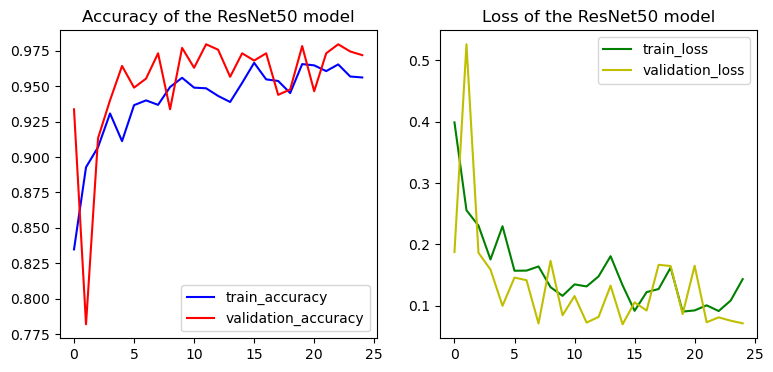

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

ax[0].plot(history_resnet_50_imagenet.history['accuracy'], c = 'b', label = 'train_accuracy')
ax[0].plot(history_resnet_50_imagenet.history['val_accuracy'], c = 'r', label = 'validation_accuracy')
ax[0].set_title('Accuracy of the ResNet50 model')
ax[0].legend()

ax[1].plot(history_resnet_50_imagenet.history['loss'], c = 'g', label = 'train_loss')
ax[1].plot(history_resnet_50_imagenet.history['val_loss'], c = 'y', label = 'validation_loss')
ax[1].set_title('Loss of the ResNet50 model')
ax[1].legend()


plt.show()

## Evaluation of the first model on the testing dataset

In [22]:
# Load the model
model = tf.keras.models.load_model('ResNet_50_ImageNet.h5')
     
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy, 2)}")

39/39 [==============================] - 8s 164ms/step - loss: 0.4355 - accuracy: 0.8333
Test loss: 0.44
Test accuracy: 0.83


## Confusion Matrix, Classification Report, AUC-ROC Curve

In [23]:
import numpy as np

# Generate predictions for the test dataset
y_pred = model.predict(test_generator)

# Since the model outputs a probability for each class, we can convert it
# into binary variables as follows:
y_pred = y_pred.round() # or y_pred = np.where(y_pred > 0.5, 1, 0)

# Get the true classes
y_true = test_generator.classes

39/39 [==============================] - 8s 186ms/step


### Confusion Matrix

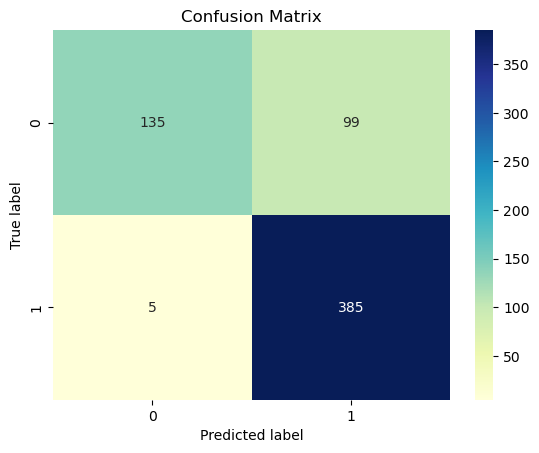

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the heatmap
sns.heatmap(confusion_mtx, annot = True, fmt = 'g', cmap = "YlGnBu")

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

### Classification Report

In [27]:
from sklearn.metrics import classification_report

# Class names
class_names = list(test_generator.class_indices.keys())

# Get the classification report
class_report = classification_report(y_true, y_pred, target_names = class_names)

# Print the classification report
print(class_report)

              precision    recall  f1-score   support

      NORMAL       0.96      0.58      0.72       234
   PNEUMONIA       0.80      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



### AUC-ROC Curve

39/39 [==============================] - 7s 165ms/step


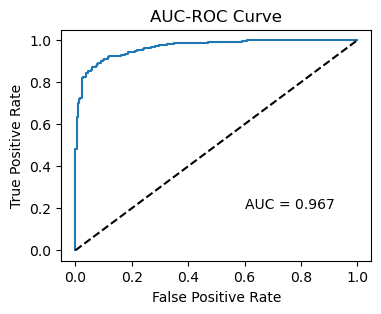

In [28]:
from sklearn.metrics import roc_curve, auc

# Generate predictions for the test dataset
y_test_pred_probs = model.predict(test_generator)

# Get the corresponding false positive rate and true positive rate for the ROC curve
FPR, TPR, _ = roc_curve(y_true, y_test_pred_probs)

# Calculate the AUC score
auc_score = auc(FPR, TPR)

# Set the size of the figure
fig, ax = plt.subplots(figsize = (4, 3))

# Plot the ROC curve
ax.plot(FPR, TPR)
ax.plot([0, 1], [0, 1], '--', color='black')  # diagonal line
ax.set_title('AUC-ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Add AUC score as text within the plot
ax.text(0.6, 0.2, f'AUC = {auc_score:.3f}', fontsize = 10)

plt.show()


## Grad-CAM for the pre-trained ResNet50 model on ImageNet dataset

In [66]:
example_image = test_generator[0][0][0]
fig = plt.figure(figsize=(4, 4))
plt.imshow(example_image)
plt.axis('off')
plt.show()

{'NORMAL': 0, 'PNEUMONIA': 1}

In [71]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    img_array = np.expand_dims(img_array, axis=0)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap

Selected Image: PNEUMONIA/BACTERIA-1135262-0001.jpeg
Selected Label: 1


In [56]:
last_conv_layer_name = "conv5_block3_out"
model.layers[-1].activation = None
heatmap = make_gradcam_heatmap(example_image, model, last_conv_layer_name)

In [57]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def save_and_display_gradcam(img, heatmap, cam_path='cam.jpg', alpha=0.005, figsize=(4, 4)):
    heatmap = np.uint8(255 * heatmap)
    jet_colors = cm.jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    fig, axes = plt.subplots(1, 2, figsize=figsize)  # Set the figsize here

    axes[0].imshow(img, aspect='auto')  # Adjust aspect ratio
    axes[0].axis('off')

    axes[1].imshow(superimposed_img, aspect='auto')  # Adjust aspect ratio
    axes[1].axis('off')

    fig.savefig(cam_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    display(Image(cam_path, width=360))


example_image = test_generator[0][0][0]
heatmap = make_gradcam_heatmap(example_image, model, last_conv_layer_name)

save_and_display_gradcam(example_image, heatmap, figsize=(20, 12))

## Transfer Learning: Pre-trained ResNet50 model on RadImageNet dataset

In [18]:
#import essential libraries and modules
from keras.applications.resnet import ResNet50
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from tensorflow.keras.models import load_model

#Pretrained ResNet50 model on the RadImageNet database
model_dir = '../input/notop-wg-radimagenet/RadImageNet-ResNet50_notop.h5'
resnet_50 = load_model(model_dir)

#Freeze the layers of ResNet50 model
for layer in resnet_50.layers:
    layer.trainable = False

def resnet_50_radimagenet():
    x = resnet_50.output
    #inputs = Input(shape = (img_width, img_height, 3))
    #x = resnet_50(inputs)
    x = Flatten()(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs = resnet_50.input, outputs = outputs)
    return model

In [19]:
model_1 = resnet_50_radimagenet()
model_1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Model 2

In [ ]:
#Import essential libraries
from tensorflow.keras.callbacks import  ModelCheckpoint
from keras.optimizers import Adam


resnet_50_radimagenet = resnet_50_radimagenet()


resnet_50_radimagenet.compile(optimizer = 'Adam',
                              loss = 'binary_crossentropy',
                              metrics = 'accuracy')

checkpoint = ModelCheckpoint(filepath = 'ResNet_50_RadImageNet.h5',
                             save_weights_only = False,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)

history_resnet_50_radimagenet = resnet_50_radimagenet.fit(train_generator,
                                validation_data = validation_generator,
                                steps_per_epoch = len(train_generator),
                                validation_steps = len(validation_generator),
                                callbacks = [checkpoint],
                                epochs = 25)

## Performance Analysis

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_resnet_50_radimagenet.history['accuracy'], c = 'b', label = 'train_accuracy')
ax[0].plot(history_resnet_50_radimagenet.history['val_accuracy'], c = 'r', label = 'validation_accuracy')
ax[0].set_title('Accuracy of the ResNet50 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_resnet_50_radimagenet.history['loss'], c = 'g', label = 'train_loss')
ax[1].plot(history_resnet_50_radimagenet.history['val_loss'], c = 'y', label = 'validation_loss')
ax[1].set_title('Loss of the ResNet50 model')
ax[1].legend()

# Show the plot
plt.show()

## Evaluation of the second model's performance on the testing dataset

In [ ]:
# Load the model
model_1 = tf.keras.models.load_model('ResNet_50_RadImageNet.h5')

# Evaluate the model on the test data
loss, accuracy = model_1.evaluate(test_generator)

print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy, 2)}")

## Comparison: ImageNet vs RadImageNet

### On the validation dataset:

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_resnet_50_imagenet.history['val_accuracy'], c = 'b', label = 'ImageNet')
ax[0].plot(history_resnet_50_radimagenet.history['val_accuracy'], c = 'r', label = 'RadImageNet')
ax[0].set_title('Accuracy of the ResNet50 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_resnet_50_imagenet.history['val_loss'], c = 'g', label = 'ImageNet')
ax[1].plot(history_resnet_50_radimagenet.history['val_loss'], c = 'y', label = 'RadImageNet')
ax[1].set_title('Loss of the ResNet50 model')
ax[1].legend()

# Show the plot
plt.show()

### On the training dataset:

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_resnet_50_imagenet.history['accuracy'], c = 'b', label = 'ImageNet')
ax[0].plot(history_resnet_50_radimagenet.history['accuracy'], c = 'r', label = 'RadImageNet')
ax[0].set_title('Accuracy of the ResNet50 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_resnet_50_imagenet.history['loss'], c = 'g', label = 'ImageNet')
ax[1].plot(history_resnet_50_radimagenet.history['loss'], c = 'y', label = 'RadImageNet')
ax[1].set_title('Loss of the ResNet50 model')
ax[1].legend()

# Show the plot
plt.show()


## On Metrics: Confusion Matrix, Classification Report, AUC-ROC Curve

In [ ]:
# Generate predictions for the validation dataset
y_pred = model_1.predict(test_generator)
y_pred = y_pred.round()

# Get the true classes
y_true = test_generator.classes

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the heatmap
sns.heatmap(confusion_mtx, annot = True, fmt = 'd', cmap = "YlGnBu")

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

### Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Class names
class_names = list(test_generator.class_indices.keys())

# Get the classification report
class_report = classification_report(y_true, y_pred,target_names = class_names)

# Print the classification report
print(class_report)

### AUC-ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc

# Generate predictions for the test dataset
y_test_pred_probs = model_1.predict(test_generator)

# Get the corresponding false positive rate and true positive rate for the ROC curve
FPR, TPR, _ = roc_curve(y_true, y_test_pred_probs)

# Calculate the AUC score
auc_score = auc(FPR, TPR)

# Set the size of the figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the ROC curve
ax.plot(FPR, TPR)
ax.plot([0, 1], [0, 1], '--', color='black')  # diagonal line
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Add AUC score as text within the plot
ax.text(0.6, 0.2, f'AUC = {auc_score:.3f}', fontsize=12)

plt.show()


## Grad-CAM for the pre-trained ResNet50 model on ImageNet dataset

In [ ]:
import matplotlib.pyplot as plt
import os

dataset_directory = "/kaggle/input/labeled-chest-xray-images" # Directory of the image
image_path = os.path.join(dataset_directory, "chest_xray/test/PNEUMONIA/BACTERIA-1768914-0003.jpeg")

example_image = plt.imread(image_path)  # Load the image

fig = plt.figure(figsize=(4, 4)) # Define the size of the image

plt.imshow(example_image, cmap = 'gray')  # Display the image
plt.axis('off') 
plt.show()

In [ ]:
def make_gradcam_heatmap(img_array, model_1, last_conv_layer_name, pred_index = None):
    img_array = np.expand_dims(img_array, axis = 0)
    grad_model = tf.keras.models.Model([model_1.inputs],
                 [model_1.get_layer(last_conv_layer_name).output, model_1.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap

In [ ]:
import numpy as np

last_conv_layer_name = "conv5_block3_out"
model_1.layers[-1].activation = None
heatmap = make_gradcam_heatmap(example_image, model_1, last_conv_layer_name)

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def save_and_display_gradcam(img, heatmap, cam_path = 'cam.jpg', alpha = 0.005, figsize = (4, 4)):
    heatmap = np.uint8(255 * heatmap)
    jet_colors = cm.jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    fig, axes = plt.subplots(1, 2, figsize=figsize)  # Set the figsize here

    axes[0].imshow(img, aspect = 'auto')  # Adjust aspect ratio
    axes[0].axis('off')

    axes[1].imshow(superimposed_img, aspect = 'auto')  # Adjust aspect ratio
    axes[1].axis('off')

    fig.savefig(cam_path, bbox_inches = 'tight', pad_inches = 0)
    plt.close(fig)
    display(Image(cam_path, width = 560))

heatmap = make_gradcam_heatmap(example_image, model_1, last_conv_layer_name)

save_and_display_gradcam(example_image, heatmap, figsize = (20, 12))

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def save_and_display_gradcam(img, heatmap, model_name, cam_path='cam.jpg', alpha=0.005, figsize=(10, 10)):
    heatmap = np.uint8(255 * heatmap)
    jet_colors = cm.jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    fig, axes = plt.subplots(2, 2, figsize=figsize)

    axes[0, 0].imshow(img, aspect='auto')
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Original Image')

    axes[0, 1].imshow(superimposed_img, aspect='auto')
    axes[0, 1].axis('off')
    axes[0, 1].set_title(f'Grad-CAM of {model_name}')

    axes[1, 0].imshow(img, aspect='auto')
    axes[1, 0].axis('off')
    axes[1, 0].set_title('Original Image')

    axes[1, 1].imshow(superimposed_img, aspect='auto')
    axes[1, 1].axis('off')
    axes[1, 1].set_title(f'Grad-CAM of {model_name}')

    fig.savefig(cam_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    display(Image(cam_path, width = 500))


heatmap_model = make_gradcam_heatmap(example_image, model, last_conv_layer_name)
heatmap_model_1 = make_gradcam_heatmap(example_image, model_1, last_conv_layer_name)

save_and_display_gradcam(example_image, heatmap_model,'the first model', figsize = (18, 12))
save_and_display_gradcam(example_image, heatmap_model_1, 'the second model', figsize = (18, 12))




## Grad-CAM for the pre-trained ResNet50 model on ImageNet dataset

In [ ]:
example_image = test_generator[0][0][0]
fig = plt.figure(figsize=(4, 4))
plt.imshow(example_image)
plt.axis('off')
plt.show()

In [ ]:
def make_gradcam_heatmap(img_array, model_1, last_conv_layer_name, pred_index = None):
    img_array = np.expand_dims(img_array, axis=0)
    grad_model = tf.keras.models.Model(
        [model_1.inputs], [model_1.get_layer(last_conv_layer_name).output, model_1.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap

In [ ]:
import numpy as np

last_conv_layer_name = "conv5_block3_out"
model_1.layers[-1].activation = None
heatmap = make_gradcam_heatmap(example_image, model_1, last_conv_layer_name)

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def save_and_display_gradcam(img, heatmap, cam_path='cam.jpg', alpha=0.005, figsize=(4, 4)):
    heatmap = np.uint8(255 * heatmap)
    jet_colors = cm.jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    fig, axes = plt.subplots(1, 2, figsize=figsize)  # Set the figsize here

    axes[0].imshow(img, aspect='auto')  # Adjust aspect ratio
    axes[0].axis('off')

    axes[1].imshow(superimposed_img, aspect='auto')  # Adjust aspect ratio
    axes[1].axis('off')

    fig.savefig(cam_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    display(Image(cam_path, width=360))


example_image = test_generator[0][0][0]
heatmap = make_gradcam_heatmap(example_image, model_1, last_conv_layer_name)

save_and_display_gradcam(example_image, heatmap, figsize=(20, 12))

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def save_and_display_gradcam(img, heatmap, model_name, cam_path='cam.jpg', alpha=0.005, figsize=(10, 10)):
    heatmap = np.uint8(255 * heatmap)
    jet_colors = cm.jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    fig, axes = plt.subplots(2, 2, figsize=figsize)

    axes[0, 0].imshow(img, aspect='auto')
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Original Image')

    axes[0, 1].imshow(superimposed_img, aspect='auto')
    axes[0, 1].axis('off')
    axes[0, 1].set_title(f'Grad-CAM of {model_name}')

    axes[1, 0].imshow(img, aspect='auto')
    axes[1, 0].axis('off')
    axes[1, 0].set_title('Original Image')

    axes[1, 1].imshow(superimposed_img, aspect='auto')
    axes[1, 1].axis('off')
    axes[1, 1].set_title(f'Grad-CAM of {model_name}')

    fig.savefig(cam_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    display(Image(cam_path, width = 500))


example_image = test_generator[0][0][0]
heatmap_model = make_gradcam_heatmap(example_image, model, last_conv_layer_name)
heatmap_model_1 = make_gradcam_heatmap(example_image, model_1, last_conv_layer_name)

save_and_display_gradcam(example_image, heatmap_model,'the first model', figsize=(18, 12))
save_and_display_gradcam(example_image, heatmap_model_1, 'the second model', figsize=(18, 12))